# Analysis of termhood

This notebook contains most parts of the analysis on term, the importance of a term within a corpus of a certain domain.

In [1]:
CORPUS_NAME = 'genia'
MODEL_SPEC = '_noskip_all'
FREQ_THRESHOLD = 3
C_VALUE_THRESHOLD = 2
SKIPGRAMS = True

In [2]:
import os
os.chdir('..')  # get to the root directory of the project

from datautils import dataio, annotations as anno
from stats import ngramcounting

# load the corpora
corpus = dataio.load_corpus(CORPUS_NAME)
print('Loading n-gram model')
model = ngramcounting.NgramModel.load_model(CORPUS_NAME, MODEL_SPEC)

Loading GENIA corpus ... NOTE: 13 files cannot get Constituent annotations!


100%|██████████| 1599/1599 [00:11<00:00, 141.64it/s]


Loading n-gram model


## Question 1: What is the termhood of concepts incl. and excl. the counts of DC's?

In [3]:
# get all continuous concepts

from stats import conceptstats
cont_concepts = conceptstats.gold_standard_concepts(corpus, discontinuous=False)
disc_concepts = conceptstats.gold_standard_concepts(corpus, continuous=False)

Retrieving gold standard concepts ... Skipped 3 concepts not bounded at tokens boundaries.
Retrieving gold standard concepts ... Skipped 0 concepts not bounded at tokens boundaries.


In [4]:
from stats import conceptstats

In [5]:
term_freqs = conceptstats.count_concepts(corpus, discontinuous=False)
doc_freqs = conceptstats.count_concepts(corpus, discontinuous=False,
                                        doc_frequency=True)

In [7]:
c_values = conceptstats.calculate_c_values(cont_concepts, C_VALUE_THRESHOLD,
                                           term_freqs)
tf_idfs = conceptstats.calculate_tf_idf_values(cont_concepts, term_freqs,
                                               doc_freqs, len(corpus))

In [8]:
all_concepts = cont_concepts.union(disc_concepts)
term_freqs_incl_dc = conceptstats.count_concepts(corpus)
doc_freqs_incl_dc = conceptstats.count_concepts(corpus, doc_frequency=True)

In [9]:
c_values_incl_dc = conceptstats.calculate_c_values(all_concepts, C_VALUE_THRESHOLD,
                                                   term_freqs_incl_dc)
tf_idfs_incl_dc = conceptstats.calculate_tf_idf_values(all_concepts, term_freqs_incl_dc,
                                                       doc_freqs_incl_dc, len(corpus))

In [13]:
glossex_values = {concept: conceptstats.glossex(concept, model)
                  for concept in all_concepts}

In [33]:
import pandas as pd

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'concept': [], 'freq': [], 'c-value': [], 'tf-idf': [],
             'freq_INCL' : [],'c-value_INCL': [], 'tf-idf_INCL': [],
             'glossex': [], 'type': []}



for concept in all_concepts:
    
    data_dict['concept'].append(concept)
    data_dict['freq'].append(term_freqs[concept])
    data_dict['freq_INCL'].append(term_freqs_incl_dc[concept])
    
    data_dict['c-value'].append(c_values[concept] if concept in c_values else None)
    data_dict['tf-idf'].append(tf_idfs[concept] if concept in tf_idfs else None)
    data_dict['c-value_INCL'].append(c_values_incl_dc[concept])
    data_dict['tf-idf_INCL'].append(tf_idfs_incl_dc[concept])
    data_dict['glossex'].append(glossex_values[concept])
    
    if concept in cont_concepts:
        if concept in disc_concepts:
            concept_type = 'both'
        else:
            concept_type = 'only_CC'
    elif concept in disc_concepts:
        concept_type = 'only_DC'
    else:
        concept_type = 'neither'
    
    data_dict['type'].append(concept_type)


data = pd.DataFrame(data_dict)

<IPython.core.display.Javascript object>


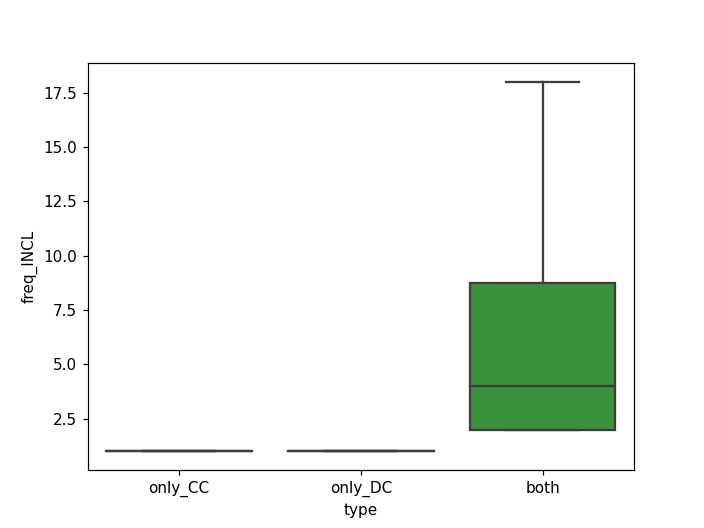

In [35]:
import seaborn as sns
sns.boxplot(x='type', y='freq_INCL', data=data, showfliers=False)

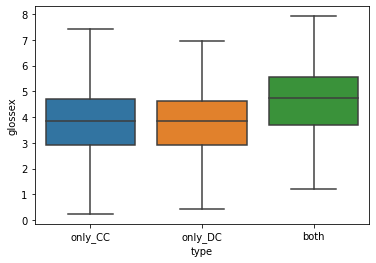

In [19]:
sns.boxplot(x='type', y='glossex', data=data, showfliers=False)

In [22]:
%matplotlib notebook
import seaborn

<IPython.core.display.Javascript object>


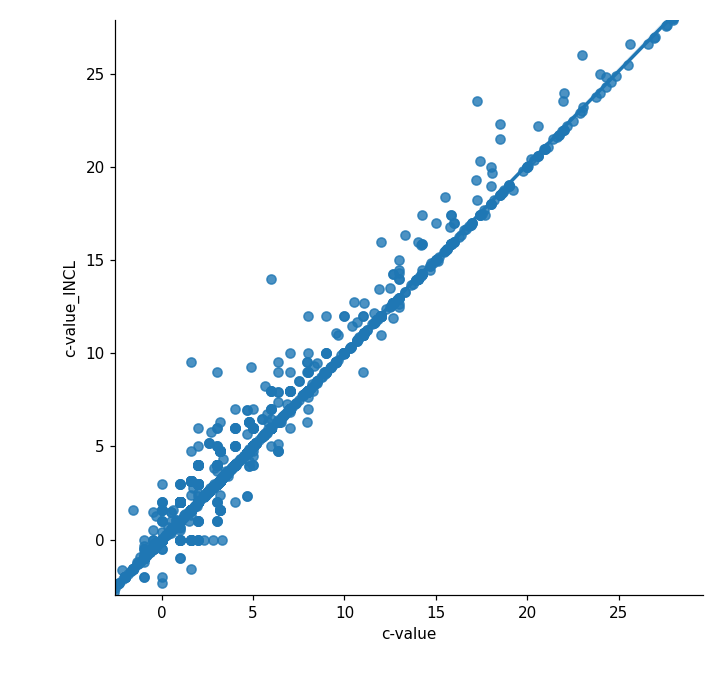

In [28]:
sns.lmplot(x='c-value', y='c-value_INCL', data=data)

<IPython.core.display.Javascript object>


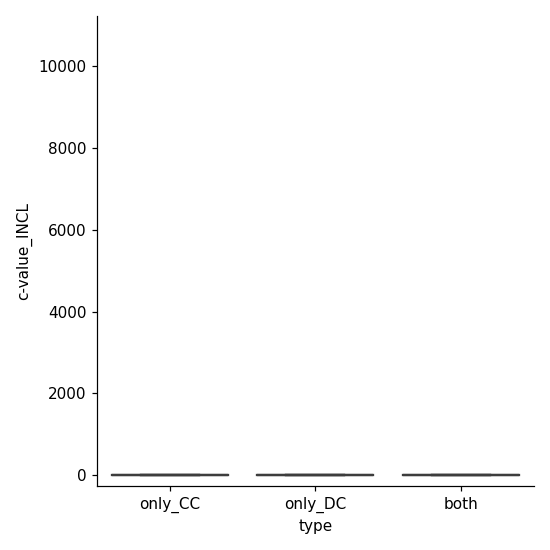

In [29]:
sns.lmplot(x='tf-idf', y='tf-idf_INCL', data=data)

<IPython.core.display.Javascript object>


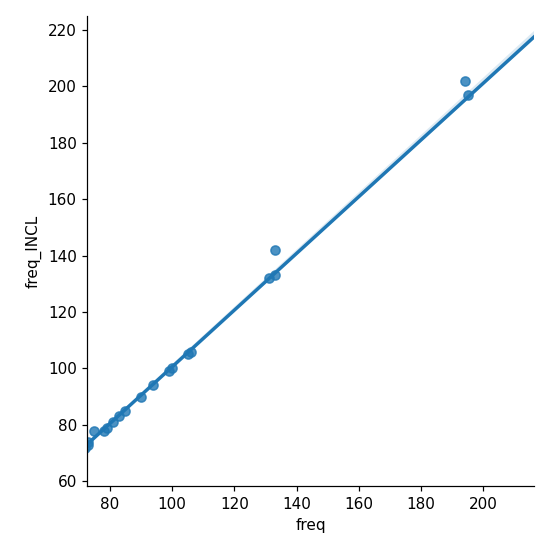

In [36]:
sns.lmplot(x='freq', y='freq_INCL', data=data)

In [ ]:
# we can perform t-tests etc.

Conclusion: Most DC's that we are interested in also occur as CC's, thus making them verifiable. The inclusion of these can enhance the term extraction recall and ranking.